In [1]:
# include the power socket setup, base classes and helpers
# (see PowerSocketSystem.py)
from PowerSocketSystem import *

# Thompson Sampling

Up to now, all of the methods we've seen have used an average of the rewards received to select an action. Thompson sampling takes a slightly different approach; rather than just refining an estimate of the mean reward, it extends this to build up a probability model from the obtained rewards and then samples from this to choose an action. In this way, not only is an increasingly accurate estimate of the possible reward obtained, but the model also provides a level of confidence in this reward, and this confidence increases as more samples are collected. This process of updating your beliefs as more evidence becomes available is known as <b><i>Bayesian Inference</i></b>.

### Bernoulli Thompson Sampling

To make things easier to work with, let's simplify the power socket problem. Now, instead of each socket returning a varying amount of charge, each socket will either return some charge or no charge; the rewards have only two possible values: 1 when the chosen socket supplies a charge and 0 when it doesn't. Additionally, the probability of a socket producing a charge varies with each socket. We want to find the socket with the highest probability of returning a charge. When a random variable has only two possible outcomes its behaviour can be described by the __[Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution)__.



As described, in Thompson sampling a model of the reward probabilities is created. When, as in this case, the available rewards are binary (win or lose, yes or no, charge or no charge) then the __[Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)__ is ideal to model this type of probability. This distribution takes two parameters, 'α' (alpha) and 'β' (beta). In the simplest terms these parameters can be thought of as respectively the count of successes and failures. 



Additionally, a Beta distribution has a mean value given by:

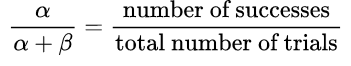

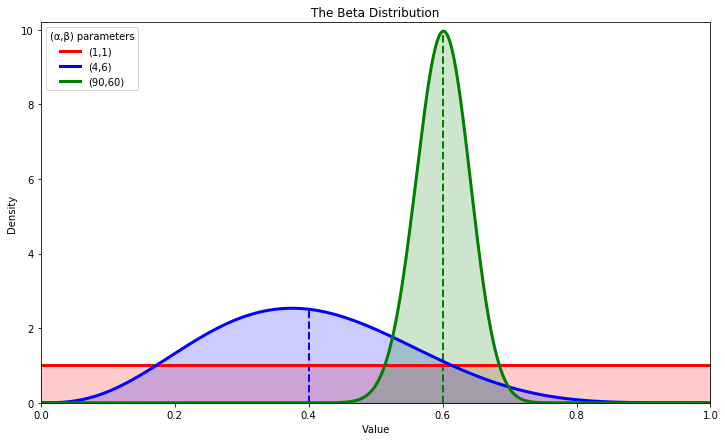

In [2]:
beta = stats.beta

params = [(1, 1),(4,6),(90,60)]
x = np.linspace(0.0, 1.0, 10000)

plt.figure(figsize=(12,7))

colors = ["red","blue","green"]
c_index = 0

for α, β in params:
    y = beta.pdf(x, α, β)
    c = colors[c_index]
    lines = plt.plot(x,y,label = f"({α},{β})",lw = 3, color = c)
    plt.fill_between(x, 0, y, alpha = 0.2, color = c)
    
    if α > 1:
        mean = α/(α+β)
        plt.vlines(mean, 0, beta.pdf(mean, α, β), colors = c, linestyles = "--", lw = 2)    
    
    plt.autoscale(tight=True)
    c_index += 1
    
plt.title('The Beta Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

plt.ylim(0,10.2)
plt.legend(loc = 'upper left', title="(α,β) parameters");

Initially we have no idea what the probability is of any given socket producing an output, so we can start by setting both 'α' and 'β' to one, which produces a flat line, __[Uniform distribution](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous))__ (shown as the flat, red, line in figure 5.1).

This initial guess at the probability of the socket producing an output is known as the __[Prior Probability](https://en.wikipedia.org/wiki/Prior_probability)__; it is the probability of the specific event occurring before we have collected any evidence and in this case is represented by the Beta distribution Beta(1,1).

Once we test a socket, and obtain a reward, we can modify our belief in the likelihood of that socket returning some charge. This new probability, after some evidence has been collected, is known as the __[Posterior Probability](https://en.wikipedia.org/wiki/Posterior_probability)__. Again this is given by a Beta distribution, but now the values of 'α' and 'β' are updated with value of the returned reward.

So, if a socket returns some charge, the reward will be 1 and 'α', the count of the number of successes, will increment by 1. The count of the number of failures, 'β', will not increase. If instead no reward was obtained, then 'α' will stay the same and 'β' will increment by 1. As data is collected the Beta distribution moves from being a flat line to become an increasingly accurate model of the probability of the mean reward. By maintaining the values of 'α' and 'β' a Thompson sampling algorithm is able to describe the estimated mean reward and the level of confidence in this estimate.

In contrast to the Greedy algorithm, which at each time step selects the action with the highest estimated reward, even if the confidence in that estimate is low, Thompson sampling instead samples from the Beta distribution of each action and then chooses the action with the highest returned value. Since actions that have been tried infrequently have wide distributions (see the blue curve in figure 5.1), they have a larger range of possible values. In this way, a socket that currently has a low estimated mean reward, but has been tested fewer times than a socket with a higher estimated mean, can return a larger sample value and therefore become the selected socket at this time step.

As the number of trials of a socket increases, the confidence in the estimated mean increases. This is reflected in the probability distribution becoming narrower and the sampled value will then be drawn from a range of values that are closer to the true mean (see the green curve in figure 5.1). As a result, exploration decreases and exploitation increases, since the sockets with a higher probability of returning a reward will begin to be selected with increasing frequency. 

On the other hand, sockets with a low estimated mean will start to be selected less frequently and will tend to be dropped early from the selection process. Consequently, their true mean may never be found. Since we are only interested in finding the socket with the highest probability of returning a reward, and finding it as quickly as possible, we don't care if full information of poorly performing sockets is never obtained.

The evolution of the Beta distribution for each power socket, where we are using the simpler probabilistic power sockets, can be seen in Figure 5.2 below. To keep things simple, we've reduced the number of sockets to three and these have true probabilities 0.3, 0.7 and 0.8 of returning some power when tested.

In [3]:
class BernoulliThompsonSocket( PowerSocket ):
    def __init__( self, q ):             
                
        self.α = 1  # the number of times this socket returned a charge        
        self.β = 1  # the number of times no charge was returned
        
        # pass the true reward value to the base PowerSocket             
        super().__init__(q)          
    
    def charge(self):        
        """ return some charge with the socket's predefined probability """
        return np.random.random() < self.q
                    
    def update(self,R):
        """ increase the number of times this socket has been used and 
            update the counts of the number of times the socket has and 
            has not returned a charge (alpha and beta)"""
        self.n += 1    
        self.α += R
        self.β += (1-R)
        
    def sample(self):
        """ return a value sampled from the beta distribution """
        return np.random.beta(self.α,self.β)

In [4]:
figsize(11.0, 10)
beta = stats.beta
x = np.linspace(0.0,1.0,200)

def plot_sockets(sockets, socket_probabilities ):
    
    trials = sum([socket.n for socket in sockets])
    
    colors = ["green","red","blue"]
    c_index = 0    
    
    for i in range(len(socket_probabilities)):
        
        c = colors[c_index]
        y = beta( sockets[i].α, sockets[i].β )
        p = plt.plot(x, y.pdf(x), lw=2, color=c, label = f'{sockets[i].α-1}/{sockets[i].n}')
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=0.2 )
        plt.vlines(socket_probabilities[i], 0, y.pdf(socket_probabilities[i]), colors = c, linestyles = "--", lw = 2)
        plt.autoscale(tight = "True")
        plt.title(f"{trials} Trials")
        plt.legend()
        plt.autoscale(tight=True)
        c_index += 1

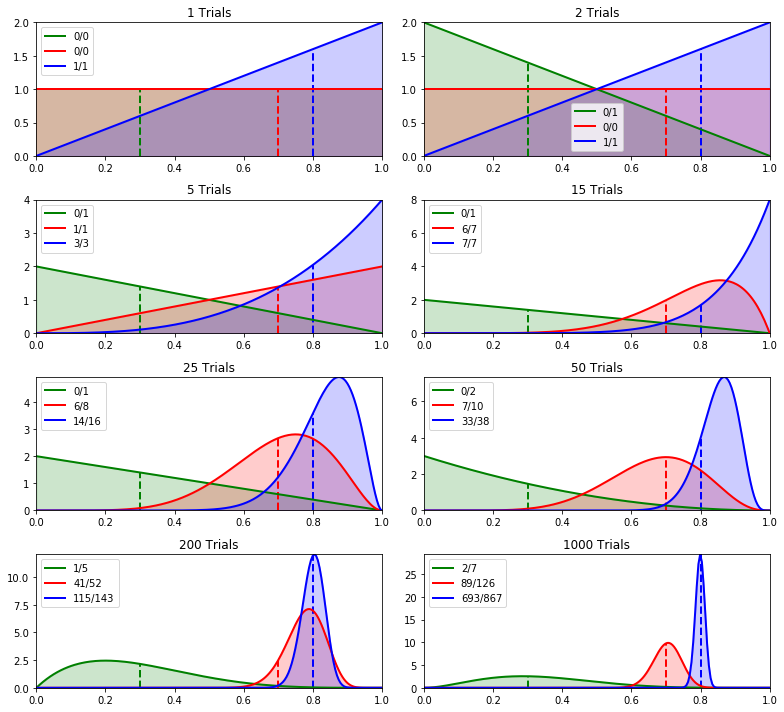

In [5]:
# set the random seed to produce a recreatable graph
seed = 15
random.seed(seed) 
np.random.seed(seed)

# the probabilities that each socket returns a charge
socket_probabilities = [0.3,0.7,0.8]

sockets = [BernoulliThompsonSocket(p) for p in socket_probabilities]

draw_samples = [1, 1, 3, 10, 10, 25, 150, 800]
for j,i in enumerate(draw_samples):
    plt.subplot(4, 2, j+1)         
    
    for k in range(i):
        # choose the socket with the current highest sampled value or arbitrary select a socket in the case of a tie            
        socket_index = random_argmax([socket.sample() for socket in sockets])     

        # charge from the chosen socket and update its mean reward value
        reward = sockets[socket_index].charge()
        sockets[socket_index].update(reward)            
        
    plot_sockets(sockets, socket_probabilities)
    
    plt.autoscale(tight = True)
plt.tight_layout()

# plt.savefig("thompson_sampling.png")

In Figure 5.2 above, the true means of 0.3, 0.7 and 0.8 are shown by the dashed lines. The legend displays the number of trials for each socket and the number of successes that have resulted from these trials.

The main points to note from Figure 5.2 are the following:

* At time step 0 (not shown) all Beta distributions will have their α and β values set to one, to give a flat Uniform distribution.

* Since all sockets have the same initial distribution, at time step 1 the blue power socket is selected arbitrarily. When tested it gives a reward, so its α value gets incremented by 1 and its probability density curve shifts to the right. The green and red sockets have not yet been tested, so retain their initial flat distribution (with the green curve being hidden behind the red curve).

* At the second time step the blue socket is again selected and again it returns a reward. The blue curve squeezes slightly more to the right, since this socket has been tested twice and has returned a reward both times, the possibility still exists that this socket will return a reward every time it is selected.

* By the 5th trial the blue socket has been selected once more, but this time it failed to give a reward. As a result the probability that it always returns a value drops to zero (at probability = 1.0). On the other hand, the green socket has now been tested twice and is yet to return a value, hence its probability density curve is shifted to the left with its highest value at probability =0, as there's still a chance this socket never returns a reward.

* At 15 trials the red socket has now been tried a couple of times. Since it's returned a reward once, it has an estimated mean reward probability of 0.5. At this stage the blue socket has been tried 11 times and has returned a reward on 6 of these trials, giving it a slightly higher estimated reward probability of 0.54. In a Greedy system the blue socket would therefore be the chosen socket, however because the red socket has been tried less times than the blue socket, it can be seen to have a much wider probability density curve, giving it a good chance of being selected in preference to the blue socket.

* The more times a socket is tested, the more confident we are in its estimate and the narrower its probability density curve becomes. The best socket will then be used more often and testing of the sub-optimal sockets will tail off. This behaviour can be seen at the end of our test, when the blue socket has been tried much more often than either of the two other sockets. It can also be seen that the green socket did finally return a reward on 2 of its trials. Consequently, it's no longer possible that this is a socket that never returns a reward, so the probability of this happening (returning a reward with probability = 0) drops to zero.

* It can also be seen that neither the blue nor red sockets have probability density curves centred exactly on their true mean probabilities. If the test was run for more time steps then the blue curve would eventually settle on the true mean value, but the red socket will have a greatly reduced number of trials (if any) and so may never come to find its true value. As mentioned, this isn't an issue, since we're only interested in finding the best socket, not the true mean values of the other sockets.

## Gaussian Thompson Sampling

The simplified socket problem we've used so far is a good way to grasp the concepts of Bayesian Thompson Sampling. However, to use this method with our actual socket problem, in which the sockets aren't binary, but instead return a variable amount of charge, we need to change things slightly.

In the previous problem we modelled the socket's behaviour using a Beta distribution. This was chosen because the simplified socket output had only two possible outcomes, some charge or no charge, and could therefore be described using a Bernoulli distribution. When a value drawn from a Bernoulli distribution (the likelihood value) is multiplied by a value drawn from a Beta distribution (the prior probability), then the resultant value (the posterior probability) also has a Beta distribution. When this occurs, such that the likelihood multiplied by the prior results in a posterior with the same distribution type as the prior, the prior is referred to as a __[Conjugate Prior](https://en.wikipedia.org/wiki/Conjugate_prior)__.

With our standard socket problem, each socket returns a real value described by a normal distribution. If, to keep things simple, we assume we know the variance of our socket, then from the __[table of conjugate priors on Wikipedia](https://en.wikipedia.org/wiki/Conjugate_prior#When_likelihood_function_is_a_continuous_distribution)__ we can see that the conjugate prior also has a normal distribution. So we can model the output of a socket using a normal distribution and gradually refine this model by updating its mean and variance parameters. If, instead of using the variance, we use the precision 'τ' (tau), where precision is just one over the variance (precision τ = 1/variance), then we can use the simple update rules for the mean 'μ₀' and precision 'τ₀' given by:


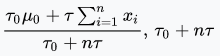


where;

'τ' is the precision of the actual socket output, which in our case is just 1.
'n' is the number of times the socket has been tested.
'xᵢ' is the output received at each test 'i' of this socket.
'μ₀' is the estimated mean (the mean of the distribution used to model the output).
'τ₀' is the precision of the distribution used to model the output.

The associated code for a Gaussian Thompson sampling socket is shown below. This retains all of the basic functionality we've used in previous socket types and adds the parameters and update function for the posterior distribution that is used to model the socket output. Note that in this update function we've replaced the summation over all of the observed rewards with 'self.n * self.Q'. This gives us exactly the same value without having to retain the sum of rewards which, as described previously, could potentially grow to become an unmanageable size.

The other main points to note are:

* Instead of simply returning 'Q', the estimate of the socket's reward value, we instead create a 'sample' function that returns a value sampled from the normal distribution that we're using to model the socket output (the posterior, with mean 'self.μ_0' and precision 'self.τ_0').

* As with the Beta distribution, used to model the socket output for binary outputs, we want our prior distribution to start with a distribution that's close to the uniform distribution, giving a flat probability distribution curve and therefore the potential to return a sampled value with a wide range of possible values. So, initially we set the precision of the posterior to be a very small value (self.τ_0 = 0.0001). In this way sockets that have not yet been tried will be more likely to be selected, much like the *Optimistic-Greedy algorithm*.

In [6]:
class GaussianThompsonSocket( PowerSocket ):
    def __init__(self, q):                
                
        self.τ_0 = 0.0001  # the posterior precision
        self.μ_0 = 1       # the posterior mean
        
        # pass the true reward value to the base PowerSocket             
        super().__init__(q)         
        
    def sample(self):
        """ return a value from the the posterior normal distribution """
        return (np.random.randn() / np.sqrt(self.τ_0)) + self.μ_0    
                    
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """   

        # do a standard update of the estimated mean
        super().update(R)    
               
        # update the mean and precision of the posterior
        self.μ_0 = ((self.τ_0 * self.μ_0) + (self.n * self.Q))/(self.τ_0 + self.n)        
        self.τ_0 += 1       

As with the Bernoulli experiment done previously, we've observed the socket selection over 1000 trials, as shown by the probability density curves below. Due to the posterior distributions starting out with almost flat curves, each socket is tested during the first 5 trials. After this, socket 4 (shown as the red curve) dominates further trials. By the end of the tests it has a tall, thin, curve centred on a value of 12 (the true socket reward value) indicating a high level of confidence in this value.

The only other socket that is tested more than once, over the set of 1000 tests, is socket 5 (the purple curve, which has a true socket reward of 10). However, it is only tested 3 times and therefore has a small, fat, distribution curve, indicating a low confidence in its value.

In [7]:
figsize(11.0, 10)

norm = stats.norm
x = np.linspace(0.0,16.0,200)

def plot_sockets(sockets, socket_probabilities ):
    
    trials = sum([socket.n for socket in sockets])              
    for socket in sockets:
                        
        y = norm.pdf( x, socket.μ_0, np.sqrt(1./socket.τ_0) )        
        p = plt.plot(x, y, lw=2, label = f'{socket.n}/{trials}')
        c = p[0].get_markeredgecolor()
        plt.fill_between(x, y, 0, color=c, alpha=0.2 )
        plt.autoscale(tight = "True")
        plt.title(f"{trials} Trials")
        plt.legend()
        plt.autoscale(tight=True)

True Values = [6, 4, 8, 12, 10]


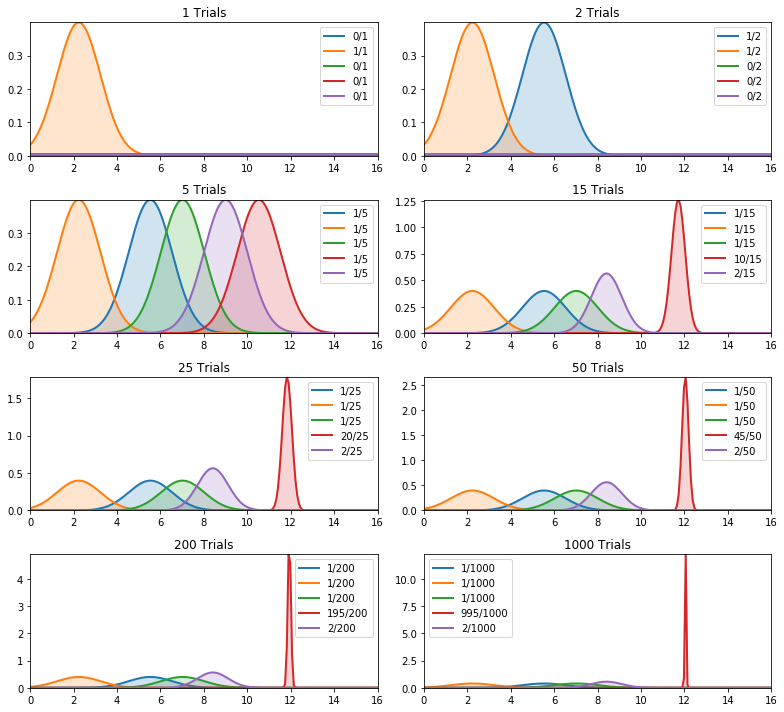

In [8]:
# set the random seed to produce a recreatable graph
seed = 15
random.seed(seed) 
np.random.seed(seed)

# create 5 sockets in a fixed order
socket_order = [2,1,3,5,4]

socket_true_values = [((q*2)+2) for q in socket_order]

print(f"True Values = {socket_true_values}")

# create the sockets
# - the mean value of each socket is derived from the socket order index, which is doubled to give 
#   distinct values and offset by 2 to keep the distribution above zero
sockets = [GaussianThompsonSocket(q) for q in socket_true_values]

draw_samples = [1, 1, 3, 10, 10, 25, 150, 800]
for j,i in enumerate(draw_samples):
    plt.subplot(4, 2, j+1)         
    
    for k in range(i):
        
        # choose the socket with the current highest sampled value or arbitrary select a socket in the case of a tie            
        socket_samples = [socket.sample() for socket in sockets]
        socket_index = random_argmax(socket_samples)     

        # charge from the chosen socket and update its mean reward value
        reward = sockets[socket_index].charge()
        sockets[socket_index].update(reward)            
        
    plot_sockets(sockets, socket_true_values)
    
    plt.autoscale(tight = True)
plt.tight_layout()

# plt.savefig("gaussian_thompson_sampling.png")

In [9]:
tester = SocketTester( GaussianThompsonSocket )
tester.run( number_of_steps = 30 )

print(f'Mean Reward per Time Step = {tester.get_mean_reward()}')
print(f'Optimal Socket Selected = {tester.get_optimal_socket_percentage():0.3f}')
print(f'Socket Percentages = {tester.get_socket_percentages()}')

Mean Reward per Time Step = 11.07276374608339
Optimal Socket Selected = 0.700
Socket Percentages = [0.033 0.033 0.067 0.700 0.167]


## Regret

In [16]:
# run the test 100 times with each test running for 1000 timesteps
number_of_tests = 1000
number_of_steps = 1000    

experiment = SocketExperiment(socket_tester   = SocketTester( GaussianThompsonSocket ),
                              number_of_tests = number_of_tests,
                              number_of_steps = number_of_steps)
experiment.run()

In [17]:
# best socket has a true mean reward of 12
cummulative_optimal_reward = [r*12 for r in range(1,number_of_steps+1)]

cummulative_optimal_reward[:10]

[12, 24, 36, 48, 60, 72, 84, 96, 108, 120]

In [18]:
experiment.get_cumulative_reward_per_timestep()[:10]

array([11.992, 23.933, 35.909, 47.918, 59.890, 71.852, 83.803, 95.805,
       107.800, 119.722])

In [19]:
# regret is the difference between the optimal reward and the actual reward 
regret = cummulative_optimal_reward - experiment.get_cumulative_reward_per_timestep()
regret[:10]

array([0.008, 0.067, 0.091, 0.082, 0.110, 0.148, 0.197, 0.195, 0.200,
       0.278])

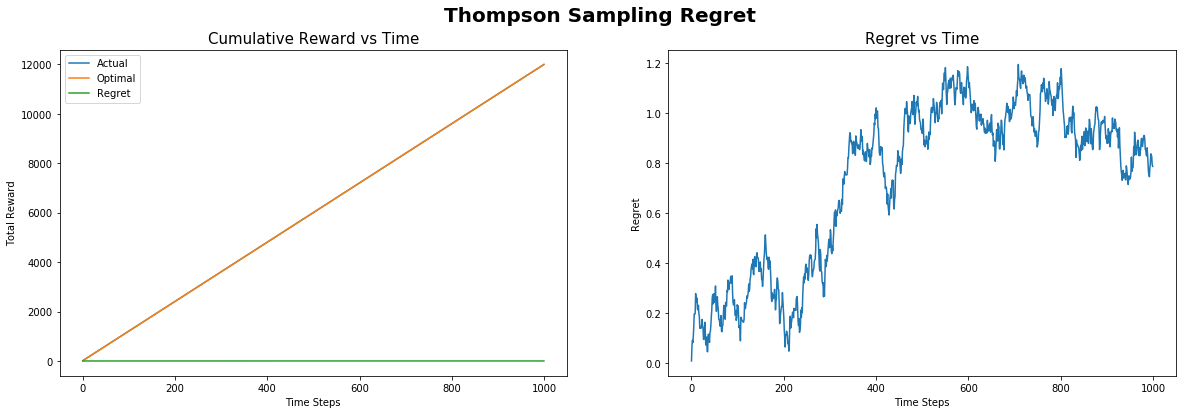

In [20]:
# best socket has a true mean reward of 12
cummulative_optimal_reward = [r*12 for r in range(1,number_of_steps+1)]

# regret is the difference between the optimal reward and the actual reward 
regret = cummulative_optimal_reward - experiment.get_cumulative_reward_per_timestep()


fig = plt.figure(figsize=(20,6))
plt.suptitle(f'Thompson Sampling Regret', fontsize=20, fontweight='bold')

plt.subplot(1, 2, 1)
plt.plot(experiment.get_cumulative_reward_per_timestep(),label = "Actual")
plt.plot(cummulative_optimal_reward, label ="Optimal")
plt.plot(regret, label ="Regret")
plt.legend()
plt.title('Cumulative Reward vs Time', fontsize=15)
plt.xlabel('Time Steps')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.title('Regret vs Time', fontsize=15)
plt.plot(regret)
plt.xlabel('Time Steps')
plt.ylabel('Regret')

plt.savefig(f"thompson_sampling_regret.png")
plt.show()  